## Paavo Reinikka, 589479

### Lab exercise #3: ELBO and GPLVMs


## Task 1: Variational inference for Gaussian Process Classification

After completing this lab exercise, you should be able to:

- Implement Variational inference for GP classification


**A mini tutorial on automatic differentiation**

When using an automatic differentiation framework to optimize a function $f: \theta \to f(\theta)$, the variable $\theta$ and/or the operations mapping from $\theta$ to $f(\theta)$ must be defined using operators from the framework.

For example to optimize $e^{\theta}+e^{-\theta}$ with respect to $\theta$ with tensorflow, you need to proceed as follows:


In [1]:
%config Completer.use_jedi = False

In [2]:
import tensorflow as tf

# define the theta variable
theta = tf.Variable(1.0, dtype=tf.float64)

# define the function
f = lambda x: tf.exp(x) + tf.exp(-x) # note the use of the tf.exp operation (not np.exp)

# run the optimization
for t in range(1000):
    # at each step, compute the gradients
    with tf.GradientTape() as tape:
        tape.watch(theta)
        loss = f(theta)
    
    gradient = tape.gradient(loss, theta)
    
    # apply the variable update (gradient descent)
    theta.assign(theta - 0.01*gradient)
    
    if t % 100 == 0:
        print(t, theta)

0 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.976495976127124>
100 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.11997260765615987>
200 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.015891416802624455>
300 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.00210746772964796>
400 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0002794913296214945>
500 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.7066015766512994e-05>
600 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.91567854916927e-06>
700 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=6.519151061083718e-07>
800 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.645669185832985e-08>
900 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.146584808250585e-08>


In [3]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

We are interested in the problem of Gaussian Process classification. 

We have some data $\mathcal{D} = \left\lbrace {\bf x}_n, y_n \right\rbrace_{n=1}^N$, with $y_n \in \{-1,1\}$.

We want to perform inference in the following generative model
$$ f \sim GP(0, k)$$
$$ p(y_n=1|{\bf x}_n) = \phi(y_n * f_n),$$
with $\phi$ the normal cumulative distribution function $\phi(x)=\int_{-\infty}^x {\cal N}(u; 0,1)du$.

We will here use a RBF kernel, with two parameters: lengthscale $l$ and variance $\sigma^2$.


The posterior is $p({\bf f}|{\bf y}) \propto p({\bf y}|{\bf f})p({\bf f})$ is intractable, hence we resort to an approximate inference scheme called variational inference.

This turns inference into optimization. We optimize the distance $d(q) = KL[q({\bf f})||p({\bf f}|{\bf y})] \geq 0$, with respect to a distribution $q({\bf f})$

We parameterize $q$ through the mean vector $m$ and the Cholesky factor of the covariance $L$: i.e. $q({\bf f})={\cal N}({\bf f}|m, S=LL^T)$

In practice we optimize the ELBO:
$${\cal L}(q) = \log p({\bf y})-d(q) = 
\underbrace{\mathbb{E}_q \log p({\bf y}|{\bf f})}_{VE} 
- \underbrace{KL(q({\bf f})||p({\bf f}))}_{KL}$$

We split the ELBO into two terms
* variational expectations (VE)
* Kullback Leibler (KL)


### Task 1a: KL divergence

For a prior $p({\bf f})={\cal N}({\bf f}|0,K)$ and a variational distribution $q({\bf f})={\cal N}({\bf f}|m, S=LL^T)$, compute the KL divergence $KL(q({\bf f})||p({\bf f}))$


You can use the formula :
$$
\begin{align*}
&KL\left(\mathcal{N}(\mu_0,\Sigma_0) \parallel \mathcal{N}(\mu_1,\Sigma_1)\right) \\ 
 &= \frac{1}{2}\left(
    \operatorname{tr}\left(\Sigma_1^{-1}\Sigma_0\right) +
    \left(\mu_1 - \mu_0\right)^\mathsf{T} \Sigma_1^{-1}\left(\mu_1 - \mu_0\right) - k +
    \ln\frac{|\Sigma_1|}{|\Sigma_0|}
  \right),\; (source: wikipedia)\\
  &= \dots \quad \text{ (bonus : can you fill the gap?)}\\
    &=
  \frac{1}{2}\left(
    \sum_{ij} (L_1^{-1}L_0)^2_{ij} +
    ||L_1^{-1}\left(\mu_1 - \mu_0\right)||^2 - k + 2\sum_{i}
    \ln |L_{1,ii}|- \ln|L_{0,ii}|
  \right).
  \end{align*}
  $$

**Note**: this needs to be adapted to the (mean,cholesky) parameterization of the multivariate Gaussian distributions.


In [ ]:
def KL(m0, L0, m1, L1):
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N x 1, mean vector
    L0, L1   -- N x N, Cholesky factor of a covariance matrix 
    returns a scalar
    """
    
    k = m0.shape[0]
    A = tf.linalg.solve(L1,L0)
    dm = m1 - m0
    b = tf.linalg.solve(L1,dm)
    
    return .5*(tf.reduce_sum(A**2) + tf.reduce_sum(b**2) - k)\
            + tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L1))\
                              -tf.math.log(tf.linalg.diag_part(L0)))
    
    

Let's check that the KL is coded properly.

For instance, noting $q_0(f) = N(f|0, I)$ and $q_1(f) = N(f|0, 2I)$, 
we should have:
* $KL[q_0||q_0] = 0$
* $KL[q_0||q_1] > 0$ 



In [5]:
K = 10
m_0 = m_1 = np.zeros((K,1))
L_0 = np.eye(K)
L_1 = np.sqrt(2.) * np.eye(K)

assert KL(m_0, L_0, m_0, L_0) == 0
assert KL(m_0, L_0, m_1, L_1) >= 0

print(KL(m_0, L_0, m_0, L_0))
print(KL(m_0, L_0, m_1, L_1))

tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.9657359027997261, shape=(), dtype=float64)


### Task 1b: Variational expectations

To compute the variational expectations $\mathbb{E}_{q(f_n)} \log p(y_n|f_n)$, we first need to compute the marginal distribution $q(f_n)$ and then compute the expectation.


In [ ]:
def q_marginals(m, L):
    """ returns the vectors of marginal means and marginal variances
    i.e, the means and variances of q(f_n)
    
    arguments:
    m   -- N x 1, mean vector
    L   -- N x N, Cholesky factor of a covariance matrix 
    returns : 2 N x 1 vectors
    """
    
    return m, tf.reduce_sum(L**2,axis=1,keepdims=True)



In [ ]:
def phi(x):
    """ Cumulative distribution function for the standard normal distribution 

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    return .5*(1 + tf.math.erf(x/math.sqrt(2)))

    
def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
    """
    #inputs = tf.clip_by_value(phi( y * f ),-3.8,3.8)
    inputs = phi( y * f )
    return tf.math.log( inputs )

    
# --------------------------------------
# The next function is given to you.
# It approximates E_q(f_n) log p(y_n|f_n) via Gaussian quadrature
# see: https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature
# --------------------------------------
def expected_log_likelihood(
    means, covs, llh, y, n_gh=10):
    """ returns the expected log likelihood terms
    
    E_q(f_n) log p(y_n|f_n)
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    arguments:
    means  -- N x 1, vector of means
    covs  -- N x 1, vector of covariances 
    llh -- log likelihood function
    y  -- N x 1, vector of observed labels 
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 x n_gh 
    inputs = means + tf.math.sqrt(2 * covs) * z.reshape(1, -1) # N x n_gh
    llh_quad = weights * llh(inputs, y) # N x n_gh

    # 'tf.reduce_sum' is tensorflow's summing function, 
    # replace if using another framework  
    return tf.reduce_sum(llh_quad, axis=1) # N, 
    

### Task 1c: ELBO

We are now ready to implement the ELBO as the difference between the variational expectations and the KL divergence:

$${\cal L}(q) = 
\underbrace{\mathbb{E}_q \log p({\bf y}|{\bf f})}_{VE} 
- \underbrace{KL(q({\bf f})||p({\bf f}))}_{KL}$$




In [ ]:
def elbo(m_p, L_p, m_q, L_q, y):
    """ returns ELBO
    L = \sum_n E_q(f_n) log p(y_n|f_n)
        + KL(q(f)||p(f))
            
    arguments:
    L_p, L_q  -- N x N, Cholesky factors of the covariances of p and q
    m_p, m_q -- N x 1, mean vector of p and q
    returns: a scalar
    """
    
    m_q, V_q = q_marginals(m_q,L_q)
    kl = KL(m_q,L_q,m_p,L_p)
    
    return tf.reduce_sum(expected_log_likelihood(m_q,V_q, classif_log_likelihood, y)) - kl
    
    

### Task 1d: Inference as optimization

We are now ready to optimize the ELBO.
We will first load some data

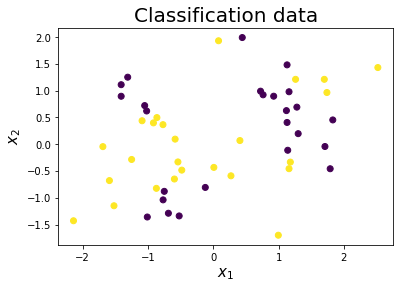

In [9]:
# Loading the data

import csv
XY = []
with open("banana.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)
XY = np.array(XY)

# Here we select a subset of the data. (remember computations scales as N^3)
N = 50
X, Y = XY[:N,:-1],XY[:N,-1:]
Y = (Y-1.5) * 2 # to be in {-1, 1}
N = X.shape[0]

# Plotting the data

plt.scatter(X[:,0], X[:,1], c=Y.flatten())
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20);

#### Preparing prior statistics

We need to compute the prior covariance $K_p = K_{\bf ff}$ and its Cholesky factor $L_p = chol(K_{\bf ff})$.

In [ ]:
# kernel parameters
l = 0.5
s = 0.5 # the standart deviation

### computing the kernel matrix K_ff

a = -1./(2*l**2)
K_ff = s**2 * np.exp(a * ( -2*X@X.T \
                        + np.sum(X**2,axis=1, keepdims=True)\
                        + np.sum(X**2,1)))

### Computing m_p, L_p = cholesky(K_p).

L_p = np.linalg.cholesky(K_ff)
m_p = np.zeros([N,1])

We initialize the variational distribution to $q({\bf f})={\cal N}({\bf f};0, I)$,
then optimize the ELBO using gradient based optimization.


Gradient based optimization refers to optimization schemes where a function $f(\theta)$ is optimized with respect to $\theta$ by following the gradient $\nabla_{\theta} f(\theta)$.
For example gradient descent construct a sequence of values $\theta_t$ following
$$\theta_{t+1 } = \theta_t + \eta \nabla_{\theta} f(\theta)|_{\theta=\theta_t}$$
where $\eta$ is the learning rate.


When using an automatic differentiation framework, one does not need to manually derive the gradient (hence the 'automatic'). Such frameworks include tensorflow, jax, pytorch (pick your favorite). These are widely used to optimize the loss function of neural network models in supervised learning.

In [11]:
# initial distribution parameters m_q, L_q
m_q = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
L_q = tf.Variable(np.eye(N), dtype=tf.float64)

# Optimize the loss: a tensorflow routine is given
loss = lambda m, L: - elbo(m_p, L_p, m, L, Y)
loss_list = []
# definition of a training step
def train(opt, m, L):
    with tf.GradientTape() as tape:
        tape.watch([m, L])
        loss_ = - elbo(m_p, L_p, m, L, Y)
    gradients = tape.gradient(loss_, [m, L])
    opt.apply_gradients(zip(gradients, [m, L]))

# you can change the optimizer or learning rate
opt = tf.optimizers.Adam(learning_rate=.0001) 

# running the optimization
for t in range(5000):
    train(opt, m_q, L_q)
    loss_list.append(loss(m_q,L_q))
    if t % 500 == 0:
        print(t, loss(m_q, L_q))   


0 tf.Tensor(48165.85679865954, shape=(), dtype=float64)
500 tf.Tensor(29347.343751934633, shape=(), dtype=float64)
1000 tf.Tensor(19069.055859185577, shape=(), dtype=float64)
1500 tf.Tensor(12738.84507739916, shape=(), dtype=float64)
2000 tf.Tensor(8704.869045232632, shape=(), dtype=float64)
2500 tf.Tensor(6073.224639339686, shape=(), dtype=float64)
3000 tf.Tensor(4315.578325100623, shape=(), dtype=float64)
3500 tf.Tensor(3109.589205596038, shape=(), dtype=float64)
4000 tf.Tensor(2260.360493875645, shape=(), dtype=float64)
4500 tf.Tensor(1651.0133249451064, shape=(), dtype=float64)


* Plot the evolution of the ELBO as a function function of iterations.

* Plot the posterior process $p(f^*|x^*, {\cal D})$.

* Plot the predictive distribution $p(y^*=1|x^*)$.

* Repeat the procedure for different values of $(\sigma^2, l)$, can you see an improvement? Is the ELBO a good proxy for hyperparameter optimization in this example?


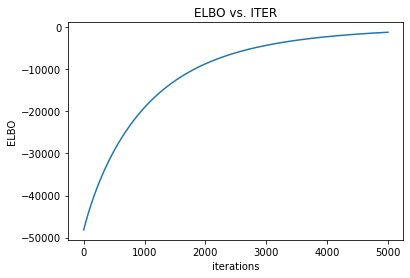

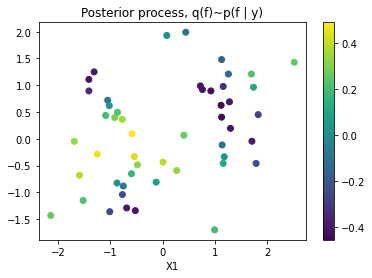

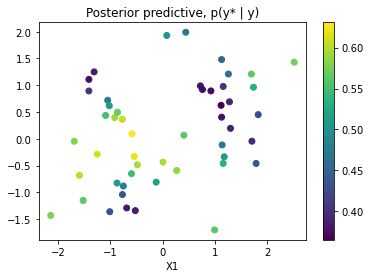

In [ ]:
plt.plot(np.arange(5000),-np.array(loss_list))
plt.xlabel('iterations')
plt.ylabel('ELBO')
plt.title('ELBO vs. ITER')
plt.show()
plt.scatter(X[:,0], X[:,1], c=np.reshape(m_q,-1))
plt.colorbar()
plt.xlabel('X0')
plt.xlabel('X1')
plt.title('Posterior process, q(f)~p(f | y)')
plt.show()
mu, sigma2 = q_marginals(m_q,L_q)
plt.scatter(X[:,0], X[:,1], c=phi(mu/np.sqrt(1+sigma2)).numpy().flatten())
plt.colorbar()
plt.xlabel('X0')
plt.xlabel('X1')
plt.title('Posterior predictive, p(y* | y)')
plt.show()

**Repeats** (I tested different combinations here - I wont display them all for clarity.)

**Conclusion:** ELBO is not a good proxy for hyperparameter optimization - it is possible, for example, to severily overfit by simply trying to optimize hyperparameters using ELBO. KL term provides some regularization, but cannot alone prevent overfitting. Plotting the predictive distribution after this kind of optimization would show that the model has not learnt any real structure, but rather just memorized the training data.

There is also a predictive plot using these values, showing the overfitting (after the next task).

0 tf.Tensor(176.22513595429174, shape=(), dtype=float64)
500 tf.Tensor(130.18899065444813, shape=(), dtype=float64)
1000 tf.Tensor(99.6007478283299, shape=(), dtype=float64)
1500 tf.Tensor(78.28110199593485, shape=(), dtype=float64)
2000 tf.Tensor(63.09513316572192, shape=(), dtype=float64)
2500 tf.Tensor(52.07872505719113, shape=(), dtype=float64)
3000 tf.Tensor(43.95048896264261, shape=(), dtype=float64)
3500 tf.Tensor(37.88594477573348, shape=(), dtype=float64)
4000 tf.Tensor(33.36128293297527, shape=(), dtype=float64)
4500 tf.Tensor(30.012864075442568, shape=(), dtype=float64)


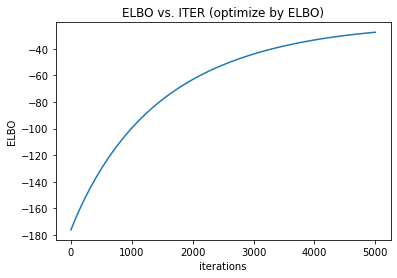

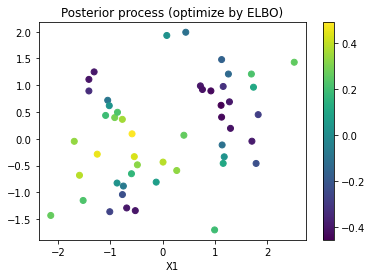

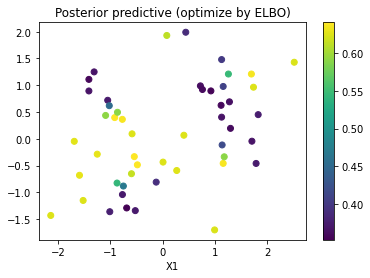

In [12]:
# kernel parameters
l = .25 #short lengthscale, and ...
s = 1 # Big amplitude => should already overfit, despite low ELBO.
### computing the kernel matrix K_ff
a = -1./(2*l**2)
K_ff = s**2 * np.exp(a * ( -2*X@X.T \
                        + np.sum(X**2,axis=1, keepdims=True)\
                        + np.sum(X**2,1)))

L_p = np.linalg.cholesky(K_ff)
m_p = np.zeros([N,1])

m_q_ELBO = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
L_q_ELBO = tf.Variable(np.eye(N), dtype=tf.float64)

loss_list = []
# definition of a training step
def train(opt, m, L):
    with tf.GradientTape() as tape:
        tape.watch([m, L])
        loss_ = - elbo(m_p, L_p, m, L, Y)
    gradients = tape.gradient(loss_, [m, L])
    opt.apply_gradients(zip(gradients, [m, L]))

opt = tf.optimizers.Adam(learning_rate=.0001) 

# running the optimization
for t in range(5000):
    train(opt, m_q_ELBO, L_q_ELBO)
    loss_list.append(loss(m_q_ELBO,L_q_ELBO))
    if t % 500 == 0:
        print(t, loss(m_q_ELBO, L_q_ELBO))  

plt.plot(np.arange(5000),-np.array(loss_list))
plt.xlabel('iterations')
plt.ylabel('ELBO')
plt.title('ELBO vs. ITER (optimize by ELBO)')
plt.show()
plt.scatter(X[:,0], X[:,1], c=np.reshape(m_q,-1))
plt.colorbar()
plt.xlabel('X0')
plt.xlabel('X1')
plt.title('Posterior process (optimize by ELBO)')
plt.show()
mu, sigma2 = q_marginals(m_q_ELBO,L_q_ELBO)
plt.scatter(X[:,0], X[:,1], c=phi(mu/np.sqrt(1+sigma2)).numpy().flatten())
plt.colorbar()
plt.xlabel('X0')
plt.xlabel('X1')
plt.title('Posterior predictive (optimize by ELBO)')
plt.show()

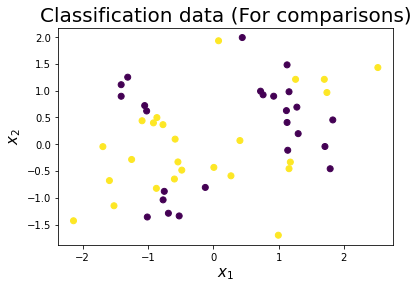

In [14]:
plt.scatter(X[:,0], X[:,1], c=Y.flatten())
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data (For comparisons)', fontsize=20);

### Task 1e: Posterior prediction for new data points

Under the hood, the algorithm defines a posterior process for all values of the input space.

For a new input $x^*$, the posterior prediction is given by 

$
\begin{align*}
q(f(x^*)) &= \int p(f(x^*)|{\bf f})q({\bf f})d{\bf f}\\
 &= {\cal N}(f(x^*)| K_{f^*{\bf f} }K_{{\bf ff}}^{-1} m_q,
 K_{f^*f^*} - K_{f^*{\bf f}}K_{{\bf ff}}^{-1}(K_{{\bf ff}} - S)K_{{\bf ff}}^{-1}K_{{\bf f} f^*})
\end{align*}
$

In [ ]:
def posterior_marginal_prediction(X_new, X, m_q, L_q):
    """ compute the posterior marginal predictions q(f(x*)) 
    independently for all inputs in X_new 
    
    Note: You need to now use tensorflow functions
  
    arguments:
    X_new -- N_new x 2, matrix of new inputs
    X     -- N x 2, matrix of training inputs
    L_q   -- N x N, Cholesky factor of the covariances of q
    m_q   -- N x 1, mean vector of q
    returns: predictive marginal means and variances (both with size N_new x 1) 
    """
    
    m_q = m_q.numpy()
    L_q = L_q.numpy()
    l=.5
    s=.5
    a = -1./(2*l**2)
    K_ff = s**2 * np.exp(a * ( -2*X@X.T \
                            + np.sum(X**2,axis=1, keepdims=True)\
                            + np.sum(X**2,1)))
    
    K_fxf = s**2 * np.exp(a * ( -2*X_new@X.T \
                            + np.sum(X_new**2,axis=1, keepdims=True)\
                            + np.sum(X**2,1)))
    
    K_fxfx = s**2 * np.exp(a * ( -2*X_new@X_new.T \
                            + np.sum(X_new**2,axis=1, keepdims=True)\
                            + np.sum(X_new**2,1)))
    
    K_S = K_ff - L_q@L_q.T
    v = np.linalg.solve(K_ff,K_fxf.T)
    return K_fxf @ np.linalg.solve(K_ff,m_q),\
            K_fxfx - v.T @ K_S @ v
    '''
    #NOTE: ----->TODO: FIX THIS
    Ki = np.linalg.inv(K_ff)
    return K_fxf@Ki@m_q,\
            K_fxfx - K_fxf@Ki@K_S@Ki@K_fxf.T
    '''
    

Plotting the prediction

In [ ]:
# create new input points on grid
n_grid = 100
x = np.linspace(X.min(), X.max(), n_grid)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([
  X1new.reshape(-1,1), X2new.reshape(-1,1)
])  # size : n_grid * n_grid x 2

In [17]:
m_res, s_res = posterior_marginal_prediction(Xnew,X,m_q,L_q)

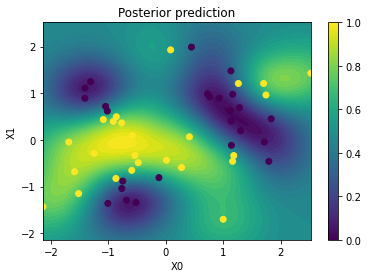

In [18]:
plt.contourf(X1new,X2new,m_res.reshape(100,100),levels=40)
plt.scatter(X[:,0], X[:,1], c=Y.flatten(),vmin=0,vmax=1)
plt.colorbar()
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Posterior prediction')
plt.show()

# ------------------------------------------------------------------------------------------------

In [ ]:
from sklearn.cluster import SpectralClustering, KMeans

In [502]:
prob = m_res.reshape(100,100)
prob1 = prob

In [20]:
prob += np.abs(prob.min())
prob /= prob.max()

In [21]:
prob.max()

1.0

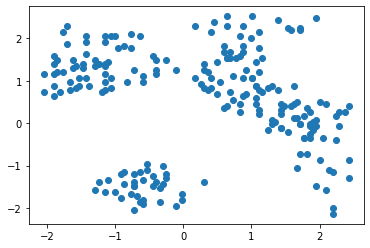

In [505]:
result = np.array((1,2))
np.random.seed(1)
for _ in range(1000):
    i = np.random.randint(0,100)
    j = np.random.randint(0,100)
    if(np.random.rand()>(1.9*prob1[i,j])):
        x1=X1new[i,j]
        x2=X1new[j,i]
        if(False):#x1>1.9 and x2<0): #198
            x1 -= .4*np.abs(np.random.randn())
            x2 -= .4*np.abs(np.random.randn())
        result = np.vstack((result, np.array([x1,x2])))
    
    
plt.scatter(result[:,0],result[:,1])
plt.show()

In [445]:
noise = np.random.rand(50,2) + np.array([-.5,.8]).reshape(1,-1)

In [446]:
result=np.vstack((result,noise))

In [447]:
result = result[np.where(result[:,1]<2)]

In [497]:
n=400
m1 = np.array([0,0])
cov1 = np.array([[5,0],[0,0.01]])
m2 = np.array([0,1])
cov2 = np.array([[100,0],[0,0.03]])

res = np.random.multivariate_normal(m1,cov1,n)
res = np.vstack((res, np.random.multivariate_normal(m2,cov2,n)))

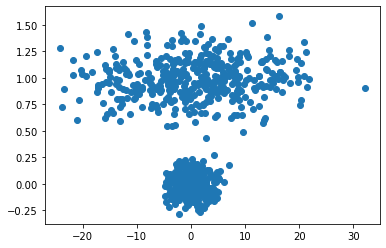

In [498]:
plt.scatter(res[:,0],res[:,1])

In [493]:
result=res

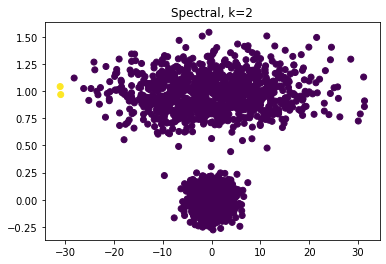

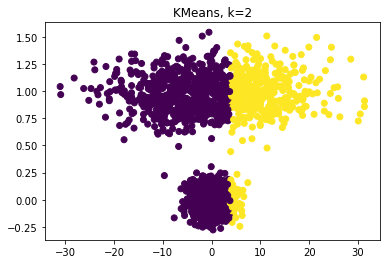

In [499]:
k=2
spec_model = SpectralClustering(n_clusters=k).fit(result)
kmeans_model = KMeans(n_clusters=k).fit(result)
plt.scatter(result[:,0],result[:,1], c=spec_model.labels_)
plt.title('Spectral, k=2')
plt.show()
plt.scatter(result[:,0],result[:,1], c=kmeans_model.labels_)
plt.title('KMeans, k=2')
plt.show()

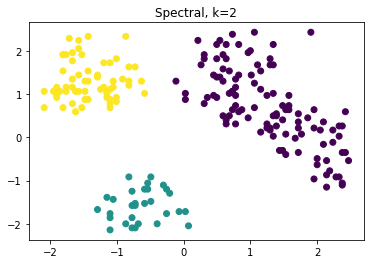

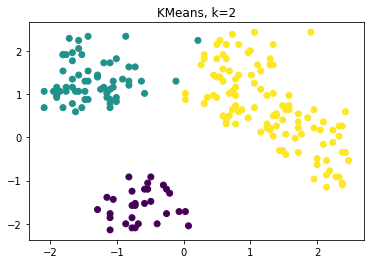

In [263]:
plt.scatter(result2[:,0],result2[:,1], c=spec_model.labels_)
plt.title('Spectral, k=2')
plt.show()
plt.scatter(result2[:,0],result2[:,1], c=kmeans_model.labels_)
plt.title('KMeans, k=2')
plt.show()

**EXTRA, PROBLEM WITH ELBO HYPERPARAM OPT:**

This is what the preditions would look like with the overfitted variational approximation:

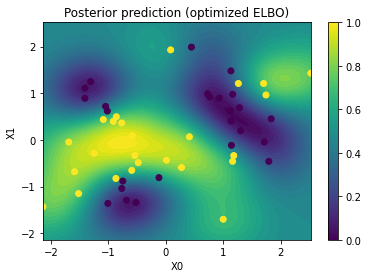

In [19]:
m_q_ELBO = m_q#.numpy()
L_q_ELBO = L_q#.numpy()
m_res, s_res = posterior_marginal_prediction(Xnew,X,m_q_ELBO,L_q_ELBO)
plt.contourf(X1new,X2new,m_res.reshape(100,100),levels=40)
plt.scatter(X[:,0], X[:,1], c=Y.flatten(),vmin=0,vmax=1)
plt.colorbar()
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Posterior prediction (optimized ELBO)')
plt.show()

# Task 2: GPLVM's

Latent variable models attempt to capture hidden structure in high dimensional
data. Given a collection of
high-dimensional observations (e.g., images), we can posit some low-dimensional
latent structure. We assume that, conditional on the latent structure, the large
number of outputs (pixels in the image) are independent of each other. Training
in this model consists of
   1. optimizing model parameters (kernel function parameters as well as, e.g.,
   observation noise variance), and
   2. finding, for each training observation (image), a corresponding point
   location in the index set.
All of the optimization can be done by maximizing the marginal log likelihood of
the data.

## Imports

For these tasks you Tensorflow, gpflow and GPy libraries. 

In [24]:
import numpy as np
np.random.seed(1)  # for reproducibility
import matplotlib.pyplot as plt

import tensorflow as tf
import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

from sklearn.decomposition import PCA

%pylab inline
%matplotlib inline

set_default_float(np.float64)
set_default_summary_fmt("notebook")

Populating the interactive namespace from numpy and matplotlib


C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gradient', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [25]:
def load_MNIST(N=500):
    import random

    (y_train, labels_train), (_, _) = tf.keras.datasets.mnist.load_data()

    # Shuffle data and subsample
    new_idx = np.arange(y_train.shape[0])
    np.random.shuffle(new_idx)
    y_train, labels_train = y_train[new_idx, :, :], labels_train[new_idx]
    sub_y_train = y_train[:N, ...].astype(np.float64) / 256.
    labels = labels_train[:N]
    y = sub_y_train.reshape(N, -1)

    def view_MNIST():
        # Lets look at the sub sampled data
        rand_idx = np.random.randint(0, N-1)
        plt.imshow(y[rand_idx, :].reshape((28,28)), interpolation='none', cmap='Greys')
        plt.title(f'Random sample with label {labels[rand_idx]}')
        plt.show()

    view_MNIST()

    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, labels

def load_three_phase_oil():
    data = np.load("./data/three_phase_oil_flow.npz")
    y =data["Y"]
    labels = data["labels"]
    
    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, labels

def load_swiss_roll(N=500):
    from sklearn import datasets
    y, color = datasets.make_swiss_roll(n_samples=N)
    
    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, color

def load_decampos_digits():
    import GPy
    which = [0,1,2,6,7,9] # which digits to work on
    data = GPy.util.datasets.decampos_digits(which_digits=which)
    y = data['Y']
    labels = data['str_lbls'].ravel()
    
    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, labels



## (B)GPLVM model setup

In [26]:
# Shared model parameter set up
#latent_dim = 2                            # number of latent dimensions
#n_data_points = y.shape[0]                # number of data points
#n_data_dims = y.shape[1]                  # number of data dimensions

def create_GPLVM(kernel):
    
    X_init = ops.pca_reduce(y, latent_dim)              # Initialise latent
    
    # alternative initialisations...
    #X_init += .1*np.random.randn(X_init.shape[0],X_init.shape[1])
    #X_init = np.ones([X_init.shape[0],X_init.shape[1]])
        
    X_parameter = gpflow.base.Parameter(X_init)
    Y_tensor = gpflow.models.util.data_input_to_tensor(y)

    gplvm = gpflow.models.gpr.GPR((X_parameter, Y_tensor), kernel=kernel)
    gplvm.likelihood.variance.assign(0.01)
    
    return gplvm

def create_GPLVM_wrapped(kernel):
    # Initialise latent
    X_mean_init = ops.pca_reduce(y, latent_dim)
    
    gplvm = gpflow.models.GPLVM(
        y,
        latent_dim = latent_dim,
        X_data_mean = X_mean_init,
        kernel=kernel,
    )

    gplvm.likelihood.variance.assign(0.01)

    # Helper function
    #def get_latent(model):
    #    return 
    
    return gplvm#, get_latent

def create_BGPLVM(kernel, num_inducing=25):
    # Initialise latent
    X_mean_init = ops.pca_reduce(y, latent_dim)
    
    # Initial inducing points
    inducing_variable = tf.convert_to_tensor(
        np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
    )
    # Initialise latent variance
    X_var_init = tf.ones((y.shape[0], latent_dim), dtype=default_float())


    gplvm = gpflow.models.BayesianGPLVM(
        y,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        kernel=kernel,
        inducing_variable=inducing_variable,
    )

    gplvm.likelihood.variance.assign(0.01)
    
    return gplvm

get_latent_mean = lambda model: model.X_data_mean.numpy()
get_latent = lambda model: model.data[0].numpy()


## GPLVM and comparison to PCA

Acquiring resource: decampos_characters

Details of data: 
Examples of hand written digits taken from the de Campos et al paper on Character Recognition in Natural Images.

Please cite:
T. de Campos, B. R. Babu, and M. Varma. Character recognition in natural images. VISAPP 2009.

After downloading the data will take up 2031872 bytes of space.

Data will be stored in $HOME/tmp/GPy-datasets/decampos_characters.

Do you wish to proceed with the download? [yes/no]
characters.npy
[==============================]   5.586/5.586MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,"(4,)",float64,"[3.97388066e-05, 3.03581352e-04, 5.70291664e-04..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.12126323753531226
GPR.data[0],Parameter,Identity,,True,"(330, 4)",float64,"[[3.63054075, 12.22828175, 26.6920663..."


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\tkinter\__init__.py", line 804, in callit
    func(*args)
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend

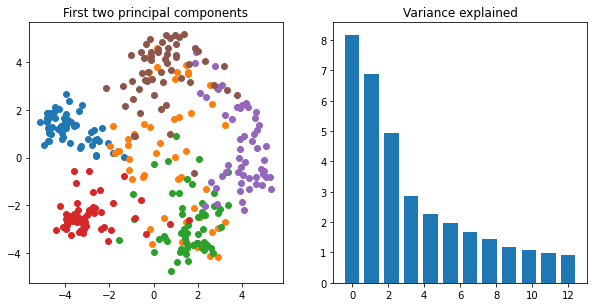

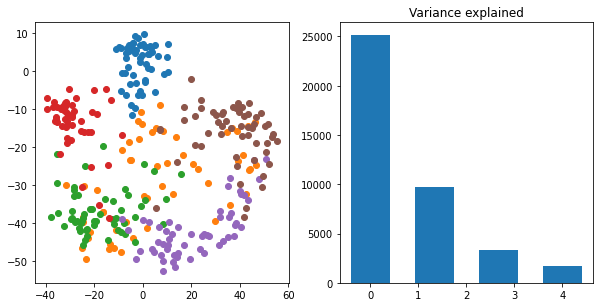

In [28]:
y, labels = load_decampos_digits()

# PCA
pca_latent = 12
pca = PCA(n_components=pca_latent)
X_pca = pca.fit_transform(y-y.mean())
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
ax[0].set_title('First two principal components')
for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=i)
ax[1].bar(np.linspace(0, pca_latent, pca_latent), pca.explained_variance_)
ax[1].set_title('Variance explained');
plt.show()

# GPLVM with linear kernel
#latent_dim = 4
latent_dim = 4#OBS
lengthscales = tf.convert_to_tensor([1.] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.Linear(variance=lengthscales)  
gplvm = create_GPLVM(kernel)
opt = gpflow.optimizers.Scipy()                       
maxiter = ci_niter(10000)
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)     
print_summary(gplvm)
order = gplvm.kernel.variance.numpy().argsort()
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
X_gplvm_linear = gplvm.data[0].numpy()[:, order]
for i in np.unique(labels):
    ax[0].scatter(X_gplvm_linear[labels == i, 0], X_gplvm_linear[labels == i, 1], label=i)
#ax[0].scatter(X_gplvm_linear[:, 0], X_gplvm_linear[:, 1], c=labels)
ax[1].bar(np.linspace(0, latent_dim, latent_dim), 1/gplvm.kernel.variance.numpy()[order])
ax[1].set_title('Variance explained');


## Task 2a

How does your linear solution differ between PCA and GPLVM with a linear kernel? Look at the plots and also try and consider how the linear ARD parameters compare to the eigenvalues of the principal components.


__Solution__

With linear kernel, GPLVM finds the same solution, possibly rotated. However, our gpflow solution is found using gradient methods, and is therefore also subject to some additional randomness. When we initialize the latents usgin pca, the iteration (presumably) stays close to the direction of gratest variance (in scatter plots there seems to be a simple 2D rotation), and mostly optimizes the ARD parameters. Overall for GPLVM, the relevance values are not directly comparable to pca's variance explained, since the different lengthscales of the latent space have to also account for the contribution of noise/nuisance dimensions (pca's variance explained is normalized against all eigenvalues, i.e., considering the full space spanned by eigenvectors). 

## Task 2b

Change the initialisation of the latent variables X_init inside the GPLVM model builder function. How this does change the results?

Hint: Try random noise, or a subset of the dimensions.

__Solution__

Using random.randn to initialize (see below), and comparing the scatter plots for 2 dominating latent directions, shows that the solutions are no longer similar. Two dominant directions are not succesful in separating the classes/labels, not to the same extent as the previous models (which still had some overlap). However, presuming linear GPLVM is reducing to dual pca, this solution should still be some rotation (in 4D?) of the previous one(s).

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,"(4,)",float64,"[2.24352020e-03, 3.17167532e-05, 1.27329580e-04..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.12126323767547269
GPR.data[0],Parameter,Identity,,True,"(330, 4)",float64,"[[12.72539453, -6.68366344, 25.67049961..."


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\tkinter\__init__.py", line 804, in callit
    func(*args)
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\paavo\anaconda3\envs\GPcourse\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend

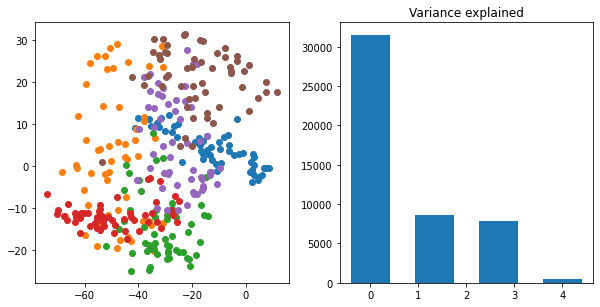

In [29]:
#EXTRA
def create_GPLVM_random(kernel):
    
    X_init = ops.pca_reduce(y, latent_dim)              # Initialise latent
    
    # alternative initialisations...
    X_init = np.random.randn(X_init.shape[0],X_init.shape[1])
    #X_init = np.ones([X_init.shape[0],X_init.shape[1]])
        
    X_parameter = gpflow.base.Parameter(X_init)
    Y_tensor = gpflow.models.util.data_input_to_tensor(y)

    gplvm = gpflow.models.gpr.GPR((X_parameter, Y_tensor), kernel=kernel)
    gplvm.likelihood.variance.assign(0.01)
    
    return gplvm

latent_dim = 4#OBS
lengthscales = tf.convert_to_tensor([1.] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.Linear(variance=lengthscales)  
gplvm = create_GPLVM_random(kernel)
opt = gpflow.optimizers.Scipy()                       
maxiter = ci_niter(10000)
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)     
print_summary(gplvm)
order = gplvm.kernel.variance.numpy().argsort()
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
X_gplvm_linear = gplvm.data[0].numpy()[:, order]
for i in np.unique(labels):
    ax[0].scatter(X_gplvm_linear[labels == i, 0], X_gplvm_linear[labels == i, 1], label=i)
#ax[0].scatter(X_gplvm_linear[:, 0], X_gplvm_linear[:, 1], c=labels)
ax[1].bar(np.linspace(0, latent_dim, latent_dim), 1/gplvm.kernel.variance.numpy()[order])
ax[1].set_title('Variance explained');


## Task 2c

The next step is to use a non-linear mapping between latent variables  __$X$__  and features  __$Y$__  by selecting the exponentiated quadratic covariance function. Run the code below.

How does choosing a non-linear kernel affect the results? Are there digits that the GPLVM with an exponentiated quadratic covariance can separate, which PCA is not able to?

__Solution__

GPLVM with exp.quadratic kernel is fitting a non-linear map between the latent and the obvservation/data space. However, there is significant overlap (labels 1,2,7,9), which I presume is a consiquence of ARD parameters having to account also for the noise/nuisance dimensions (a kind of overfitting) - ARD parameters are what account for the different scales. This can be leviated by putting a prior on the latents (which is done next).


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.3302209502897645
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(4,)",float64,"[0.48946243, 0.54171465, 6.20412083..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.04082161837205236
GPR.data[0],Parameter,Identity,,True,"(330, 4)",float64,"[[-0.41799604, -0.70918629, -2.45244889..."


<BarContainer object of 4 artists>

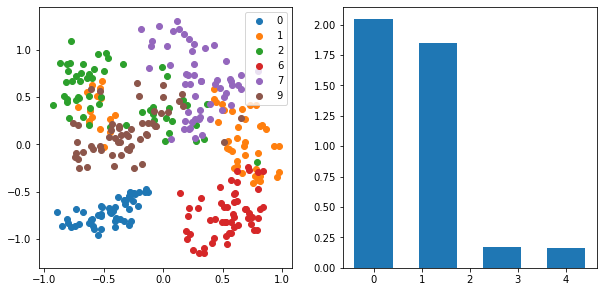

In [26]:
lengthscales = tf.convert_to_tensor([1.] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)
gplvm = create_GPLVM(kernel)

opt = gpflow.optimizers.Scipy()                       
maxiter = ci_niter(1000)
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)     
print_summary(gplvm)

order = (gplvm.kernel.lengthscales.numpy()).argsort()
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
X_gplvm_rbf = gplvm.data[0].numpy()[:, order]
for i in np.unique(labels):
    ax[0].scatter(X_gplvm_rbf[labels == i, 0], X_gplvm_rbf[labels == i, 1], label=i)
ax[0].legend()
ax[1].bar(np.linspace(0, latent_dim, latent_dim), 1/gplvm.kernel.lengthscales.numpy()[order])


## Bayesian GPLVM

GPLVM needs not make anyassumptions on the prior of latent variables. However, lack of such assumption makes the model inferred by just maximizingthe log marginal likelihood prone to overfitting. To tackle this problem, one of effective approaches is to impose a specific prior onto the latent variables for a posterior estimation. Thus, we can introduce various constraints into the prior for the estimation the latent variables in different tasks. Specifically, we assume that $p(X)$ denotes the imposed prior. By using the Bayesian theorem, we can formulate the posterior probability of the latent variables X as $p(X|Y,\theta) \propto p(Y|X,\theta)p(X)$ 



In [29]:
tf.random.set_seed(1)
lengthscales = tf.convert_to_tensor([1.] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)
bgplvm = create_BGPLVM(kernel, num_inducing=20)

# This will take minutes to run.
# You can interrupt the kernel
opt = gpflow.optimizers.Scipy()                       
maxiter = ci_niter(1000)
_ = opt.minimize(
    bgplvm.training_loss,
    method="BFGS",
    variables=bgplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)     
print_summary(bgplvm)

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,14.006935934867684
BayesianGPLVM.kernel.lengthscales,Parameter,Softplus,,True,"(4,)",float64,"[17.83439341, 2.08209159, 24.32880119..."
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.09357737585172507
BayesianGPLVM.X_data_mean,Parameter,Identity,,True,"(330, 4)",float64,"[[0.71363221, -1.00808846, 1.09520766..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(330, 4)",float64,"[[0.00758037, 0.00046247, 0.01830926..."
BayesianGPLVM.inducing_variable.Z,Parameter,Identity,,True,"(20, 4)",float64,"[[-1.87750232e+01, -1.14619185e+02, 2.27654913e+02..."


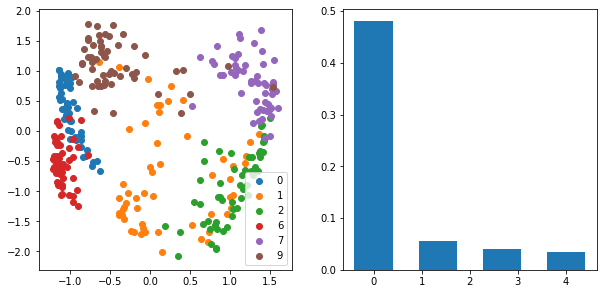

In [30]:
order = (bgplvm.kernel.lengthscales.numpy()).argsort()
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
X_bgplvm_rbf = bgplvm.X_data_mean.numpy()[:, order]
for i in np.unique(labels):
    ax[0].scatter(X_bgplvm_rbf[labels == i, 0], X_bgplvm_rbf[labels == i, 1], label=i)
ax[0].legend()
ax[1].bar(np.linspace(0, latent_dim, latent_dim), 1/bgplvm.kernel.lengthscales.numpy()[order]);


## Task 2d 

* How does the Bayesian GP-LVM compare with the GPLVM model?  
* How has the prior on $X$ affected the results?
* Are there any classes that still overlap? Why?

__Solution__

**NOTE:** Due to randomness in VI/optimization (including the initialization of the inducing points), there is some variance on the results. Overall the model does perform better than previous ones.

* GPLVM uses a point estimate (ML) for the distribution of the latents, where as Bayesian GP-LVM places a prior over the latents, and integrates the uncertainty into the solution. In Bayesian GP-LVM the true posterior $p(\mathbf{X}\mid\mathbf{Y})$ is approximated using variational approximation $q(\mathbf{X})$, and $\mathbf{X}$ is integrated out. Using the approx. posterior can suppresses certain latent dimensions - noise/nuisance dimensions, for which the ARD parameters no longer need to account for: I think this is the regularizing effect of the prior, preventing overfitting. 

* The prior prevents overfitting (mechanism mentioned above) / regularizes the model, while the rbf kernel still provides a non-linear mapping. Now a single dominant latent is explaining much of the variability in the data, and eventhough label=1 is still quite spread out, there are now more clustering. 

* Evethough there are now 6 more or less clear clusters, there is still some overlap at the boundaries (of the classes). Although less than with the previous models, label=1 is still slightly mixed with 2,7,9. It is possible that 2 dimensions are simply not enough to represent all the information in the data. (Of course, 1D would be enough to represent digits, but not enough to include all the information needed to represent the observed data - which is presumed being mapped from the latent space).

**END**